## SST datasets reveal substantial differences even during the Satellite era

Sea surface temperature (SST) is one of the most widely used variables for monitoring and understanding Earth’s climate. It serves as a cornerstone for studying phenomena ranging from long-term climate change to interannual variability associated with events like El Niño and La Niña. However, despite its foundational role, considerable differences exist across SST datasets—even during the satellite era when observations are presumed to be more consistent and globally complete.

I am happy to see a recent NCC paper [(Menemenlis et al. 2025)](https://www.nature.com/articles/s41558-025-02362-6) have highlighted these consequential discrepancies in warming trends. This has critical implications for assessing climate change and its regional impacts. This notebook reproduces key figures from that study, illustrating how SST trend estimates vary depending on the choice of dataset.

**Beyond trends, differences across SST datasets also affect representations of climate variability.** As shown in [Zhao et al. (2024, Nature)](https://www.nature.com/articles/s41586-024-07534-6)'s Supplementary Fig. 15, such discrepancies shape our understanding of El Niño dynamics and predictability. We found that SST variability characteristics differ markedly across datasets, especially for climate modes beyond ENSO, complicating efforts to attribute observed changes or predict future behavior.

Together, these findings underscore the importance of carefully evaluating and intercomparing SST products when studying both the mean state and the variability of the climate system.

This notebook show the code to reproduce Menemenlis et al. (2025)'s figures for SST trends

Reference: 
Menemenlis, S., Vecchi, G.A., Yang, W. et al. Consequential differences in satellite-era sea surface temperature trends across datasets. Nat. Clim. Chang. (2025). [https://doi.org/10.1038/s41558-025-02362-6](https://www.nature.com/articles/s41558-025-02362-6)


<p float="center">
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41558-025-02362-6/MediaObjects/41558_2025_2362_Fig1_HTML.png?as=webp" alt="ENSO" class="bg-primary mb-1" width="600px">
<figcaption align = "left"> 
</figcaption>
</p>

In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
import glob

import numpy  as np
import xarray as xr

import statsmodels.api as sm

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import senpy as sp

plt.style.use("science")

In [2]:
model_arrs = ['HadISST', 'ERSSTv5', 'COBE2', 'OISSTv2', 'ERA5']

def load_area_average_sst_trend(region=[0, 360, -60, 60], 
                                time_slice=slice('1982-01', '2024-12'),
                                clim_slice=slice('1982-01', '2024-12')):
    """
        Load multi-observational area-averaged SST time series and compute linear trends
        (with Newey–West standard errors) for each dataset.
    """
    
    model_ds_arrs = []
    for model in model_arrs:
        tmp_ds = sp.area_average( sp.OBS_onemodel_sst(model=model, vars='sst', time_slice=time_slice)['sst'], region=region).compute()
        if model == 'ERA5':
            tmp_ds = tmp_ds - 273.15
        model_ds_arrs.append( tmp_ds.assign_coords({'model': model}) )
    
    model_i_ds = xr.concat(model_ds_arrs, dim='model')
    
    model_i_ann = model_i_ds.clim.climatology(clim_slice=clim_slice).mean('month')
    model_i_a  = model_i_ds.clim.anomalies(clim_slice=clim_slice)
    model_i_ad = model_i_a + model_i_ann
    
    trend_i_ad = model_i_ad.trend_neweywest(dim='time')
    return model_i_ad, trend_i_ad

## calculate 60S-60N averaged SST
model_i_ad_60S60N, trend_i_ad_60S60N = load_area_average_sst_trend(region=[0, 360, -60, 60])

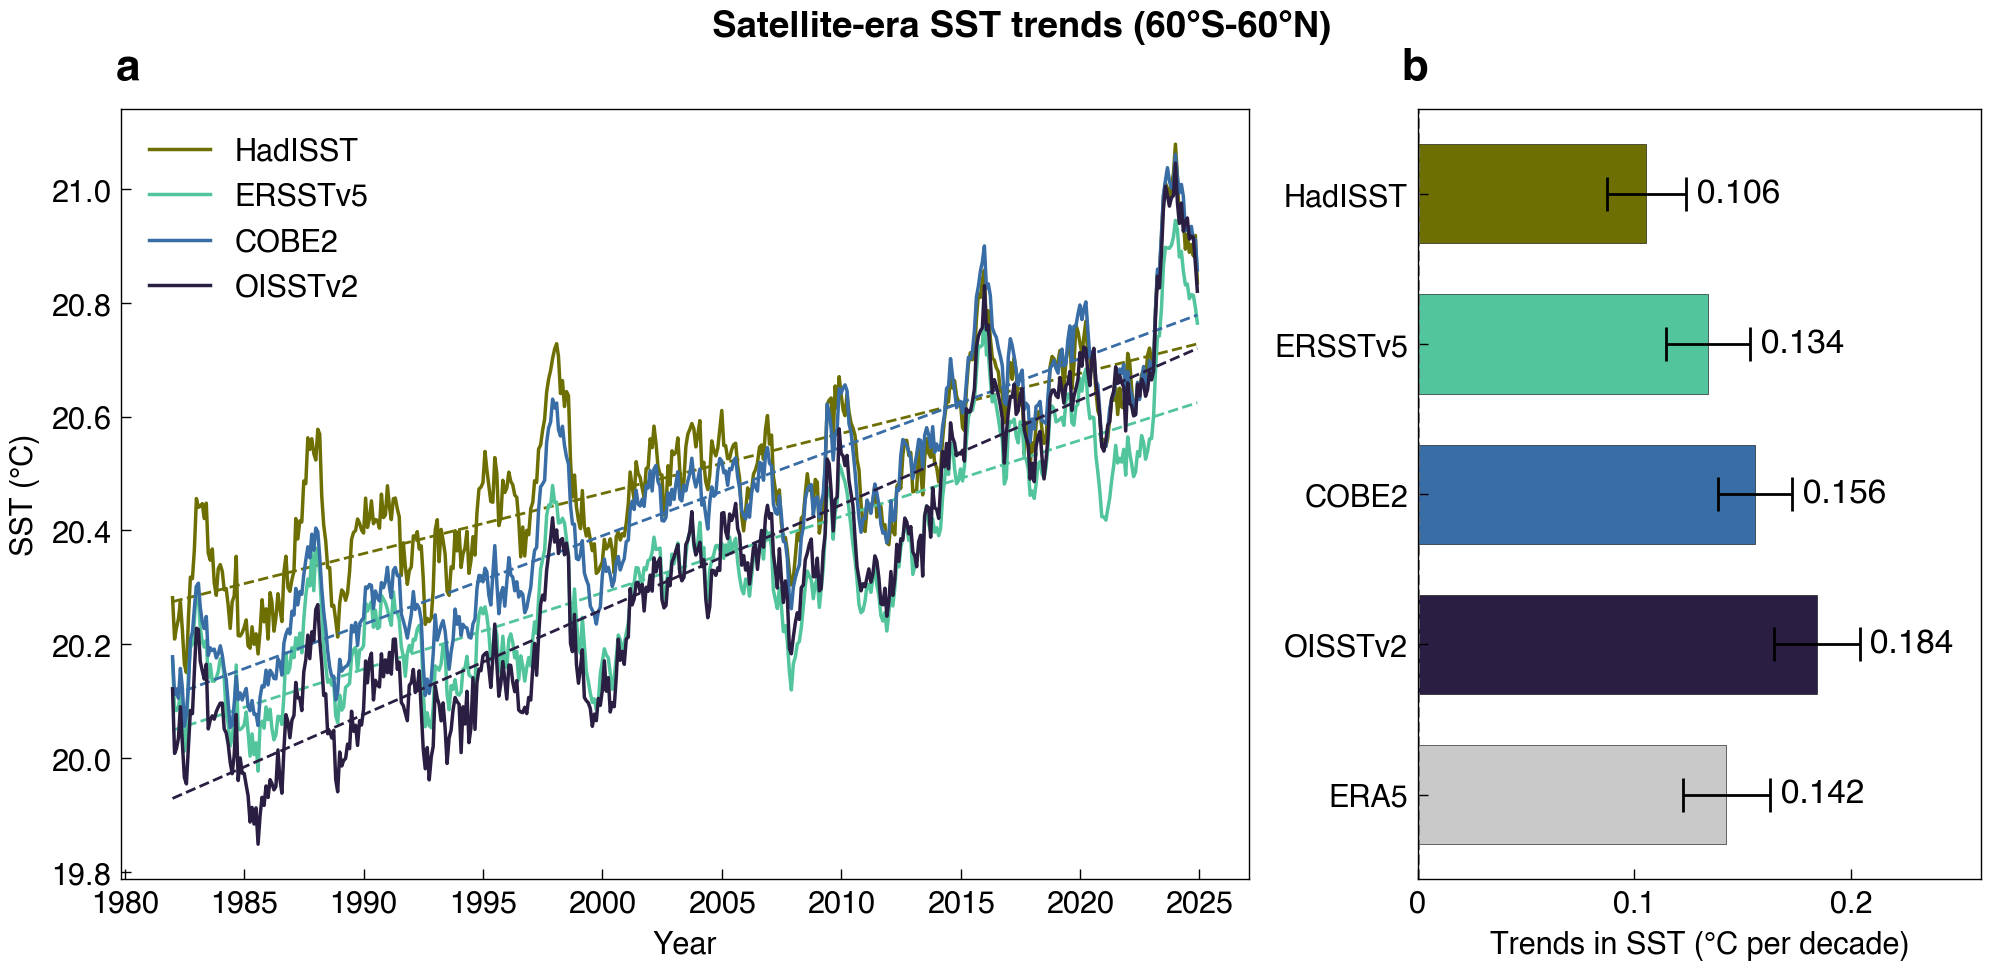

In [3]:
def plot_sst_trends(timeseries_ds, trend_ds, 
                    suptitle='Satellite-era SST trends (60°S-60°N)',
                    xlim=[0, 0.26], xticks=[0, 0.1, 0.2], xticklabels=[0, 0.1, 0.2]):

    colors = sp.cmap.colors5N3
    
    fig, (axLeft, axRight) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})
    
    # --- Left: time series + trend line ---
    for i, model in enumerate(model_arrs):
        if model == 'ERA5':
            continue
        color = colors[i]
        
        # Plot timeseries
        ts = timeseries_ds.sel(model=model)
        ts.plot(ax=axLeft, label=model, color=color, lw=1.25)
        
        # Plot trend line (simple line from start to end)
        years = ts['time'].dt.year + (ts['time'].dt.month - 1) / 12.0
        t_rel = years - years[0]
        tr_slope = trend_ds['s'].sel(model=model).values
        tr_intercept = ts.mean().values - tr_slope * t_rel.mean()  # rough centering
        
        trend_line = tr_intercept + tr_slope * t_rel
        axLeft.plot(ts['time'], trend_line, linestyle='--', color=color, lw=1)
    
    axLeft.set_xlabel("Year")
    axLeft.set_ylabel("SST (°C)")
    axLeft.set_title("")
    axLeft.legend()
    
    # --- Right: trend ±2 SE with horizontal bars + text annotations ---
    trend_values = trend_ds['s'].sel(model=model_arrs).values * 10  # °C per decade
    stderr_values = trend_ds['stderr'].sel(model=model_arrs).values * 10
    
    y_pos = np.arange(len(model_arrs))
    
    for i, model in enumerate(model_arrs):
        color = colors[i]
    
        # Bar
        axRight.barh(y_pos[i], trend_values[i], color=color, edgecolor='k', height=0.66, linewidth=0.2, capsize=5)
    
        # Explicit error bar on top with capsize
        axRight.errorbar(trend_values[i], y_pos[i],
                         xerr=stderr_values[i]*2, color=color,
                         fmt='none', ecolor='k', capsize=6, elinewidth=1.)
    
        # Annotate with trend value ± stderr
        axRight.text(trend_values[i] + stderr_values[i]*2 + 0.005, 
                     y_pos[i],
                     f"{trend_values[i]:.3f}",
                     va='center', ha='left' if trend_values[i]>=0 else 'right', fontsize=12)
    
    axRight.set_yticks(y_pos)
    axRight.set_yticklabels(model_arrs)
    axRight.invert_yaxis()
    axRight.set_xlabel("Trends in SST (°C per decade)")
    axRight.set_title("")
    axRight.axvline(0, color='gray', linestyle='--', linewidth=1)
    axRight.set_xticks(xticks)
    axRight.set_xticklabels(xticklabels)
    axRight.set_xlim(xlim)

    sp.set_legend_alphabet(fig, [axLeft, axRight], x=0.02)
    fig.suptitle(suptitle, fontweight='bold')
    return fig
    
fig = plot_sst_trends(model_i_ad_60S60N, trend_i_ad_60S60N, suptitle='Satellite-era SST trends (60°S-60°N)')
sp.savefig(fig, fname='sst_trend_60S60N_Fig1_MenmenlisS_ncc_2025.png', dpi=300)

### Tropical SST trend (30S-30N)

This is also reported in Menemenlis et al. (2025) NCC Supplementary Figure S1.

https://static-content.springer.com/esm/art%3A10.1038%2Fs41558-025-02362-6/MediaObjects/41558_2025_2362_MOESM1_ESM.pdf#page=3.00


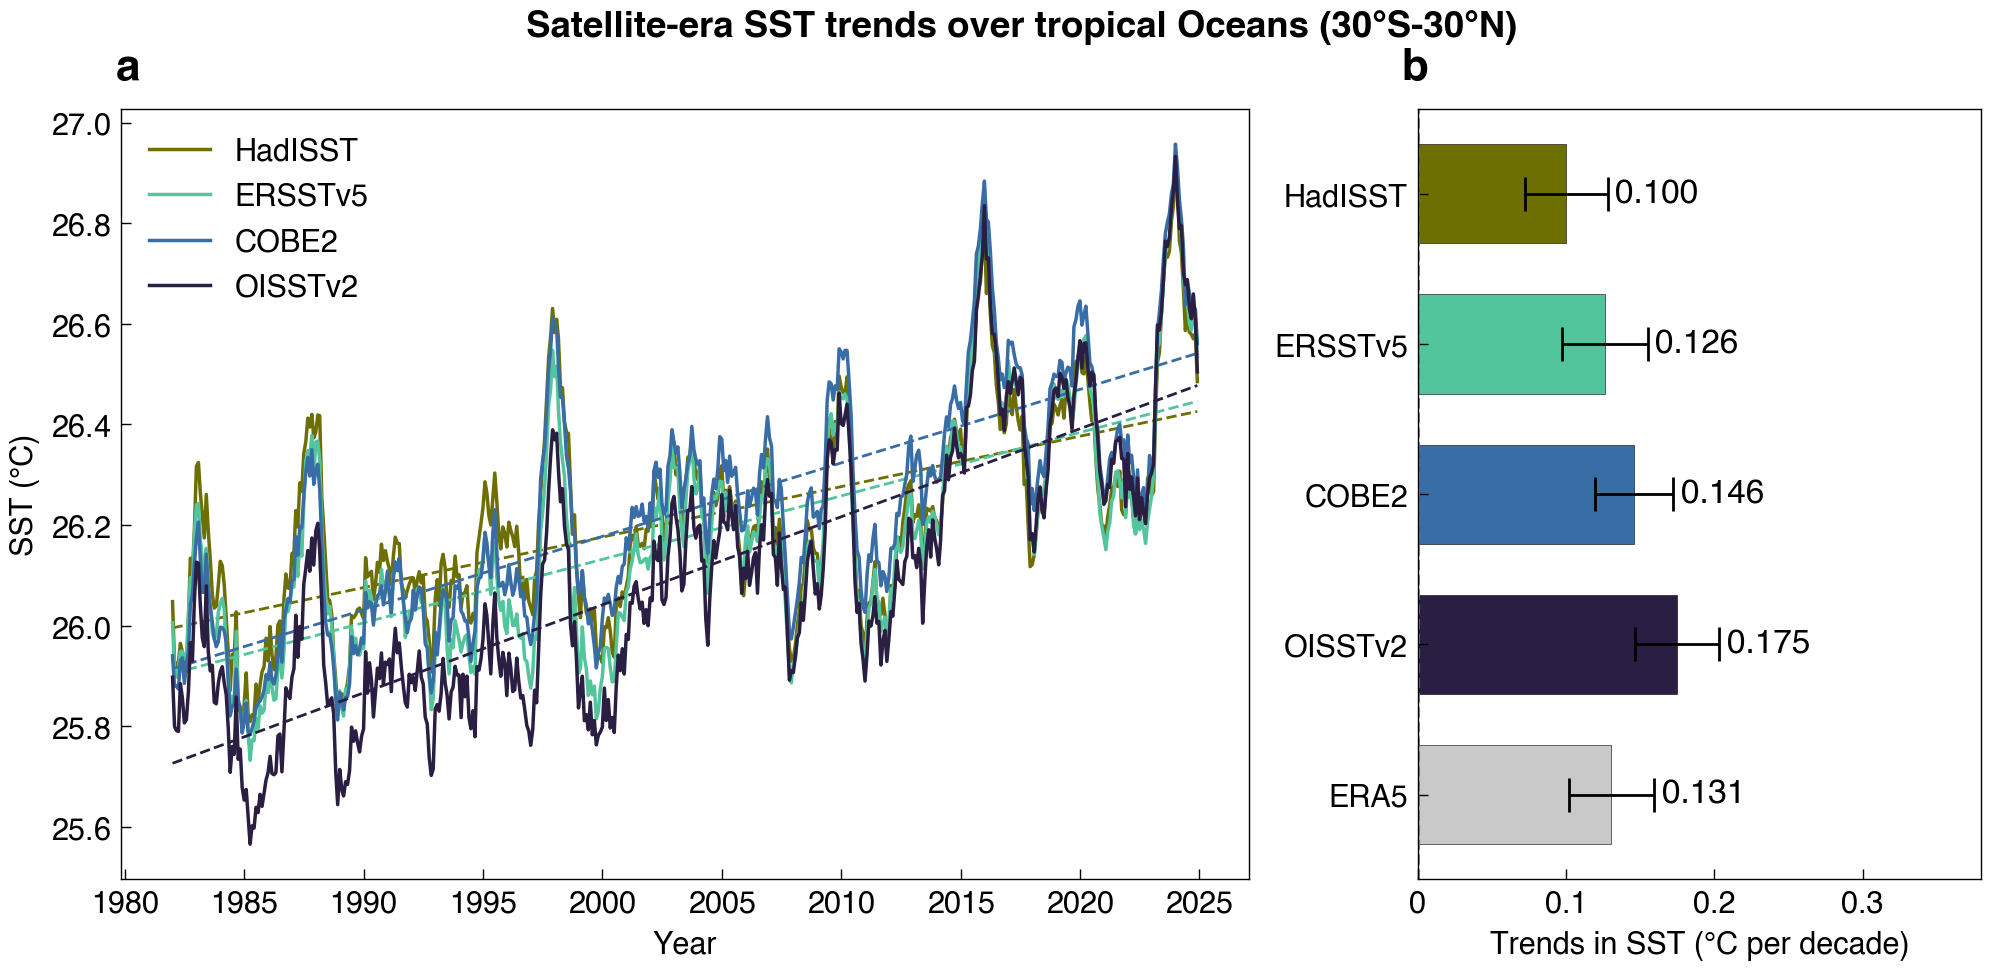

In [4]:
model_i_ad_30S30N, trend_i_ad_30S30N = load_area_average_sst_trend(region=[0, 360, -30, 30])
fig = plot_sst_trends(model_i_ad_30S30N, trend_i_ad_30S30N, suptitle='Satellite-era SST trends over tropical Oceans (30°S-30°N)', 
                     xlim=[0, 0.38], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])

### Extratropical Northern Hermisphere (30°-60°N)

It is interesting that the Extratropical Northern Hemisphere does 
<span style="color:orangered"><strong>not show large discrepancies</strong></span> 
among the datasets.

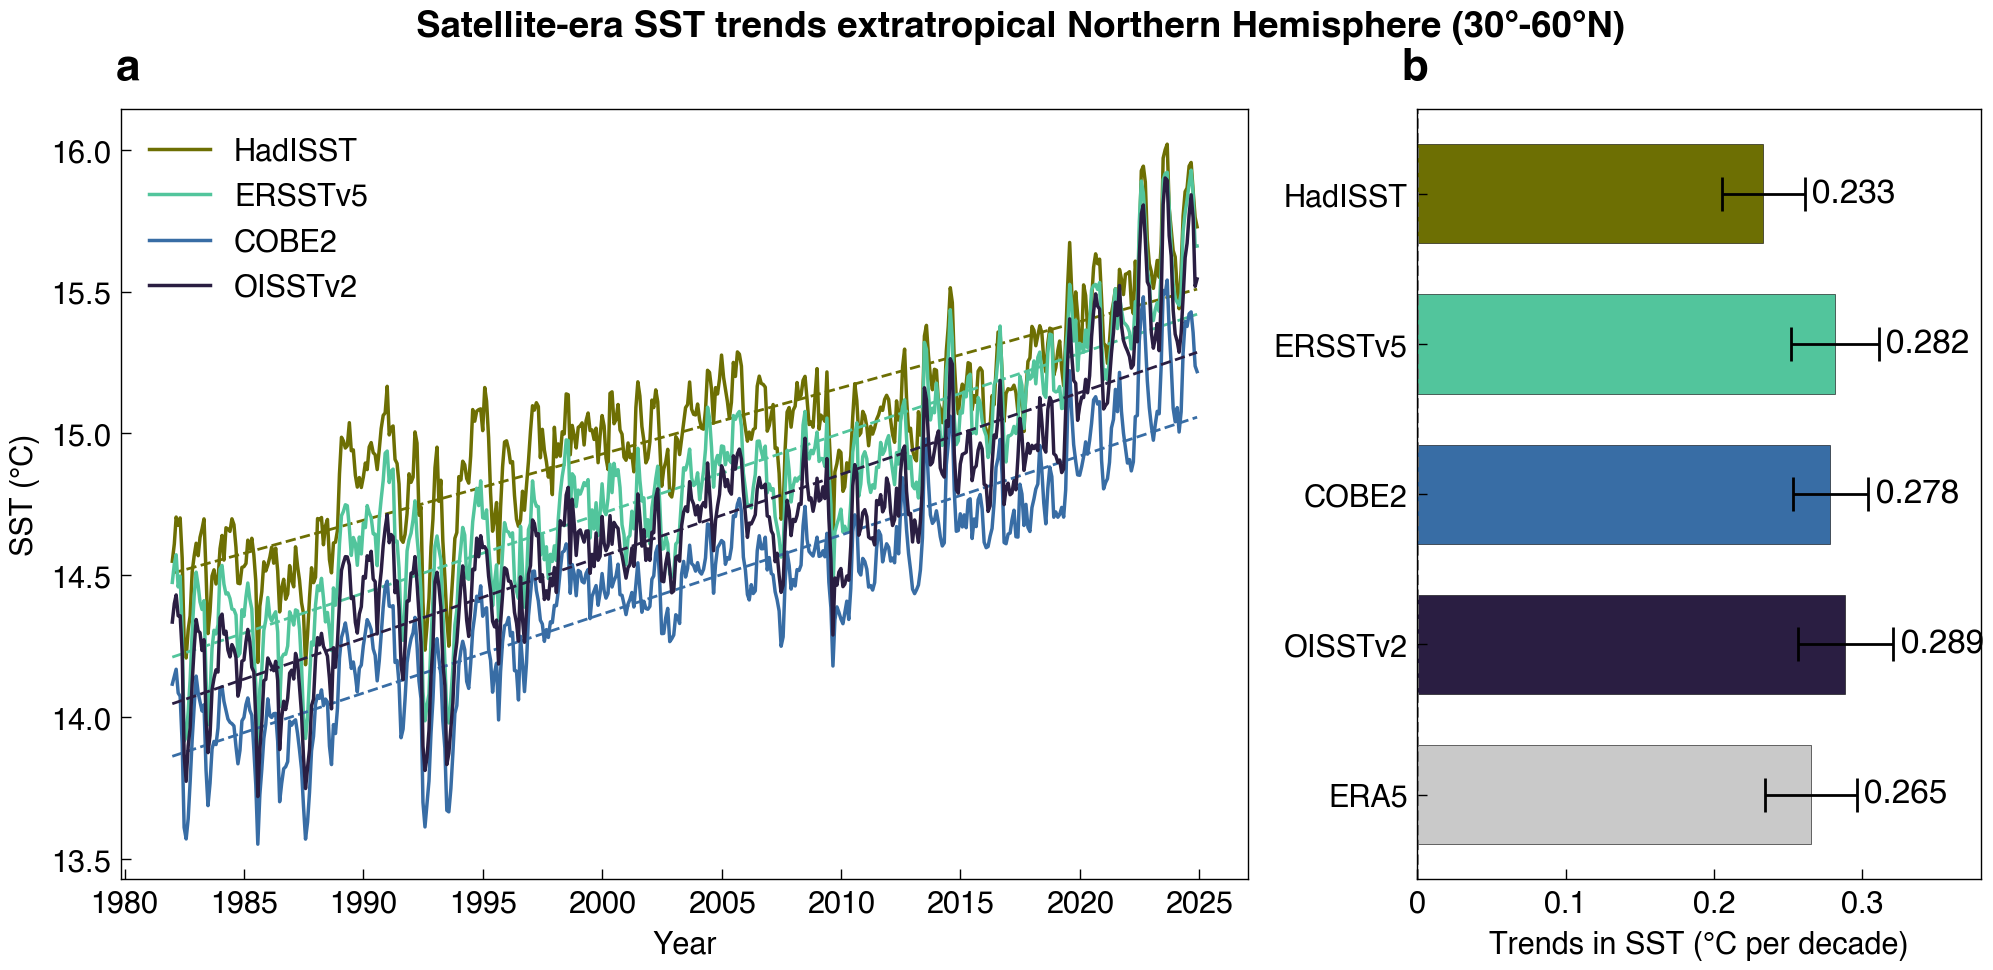

In [5]:
model_i_ad_30N60N, trend_i_ad_30N60N = load_area_average_sst_trend(region=[0, 360, 30, 60])
fig = plot_sst_trends(model_i_ad_30N60N, trend_i_ad_30N60N, suptitle='Satellite-era SST trends extratropical Northern Hemisphere (30°-60°N)', 
                     xlim=[0, 0.38], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])
sp.savefig(fig, fname='sst_trend_30N60N.png', dpi=300)

### Southern Oceans (45°-60°S)

Southern Oceans show
<span style="color:orangered"><strong> even large discrepancies</strong></span> 
among the datasets (~ 10 times difference)

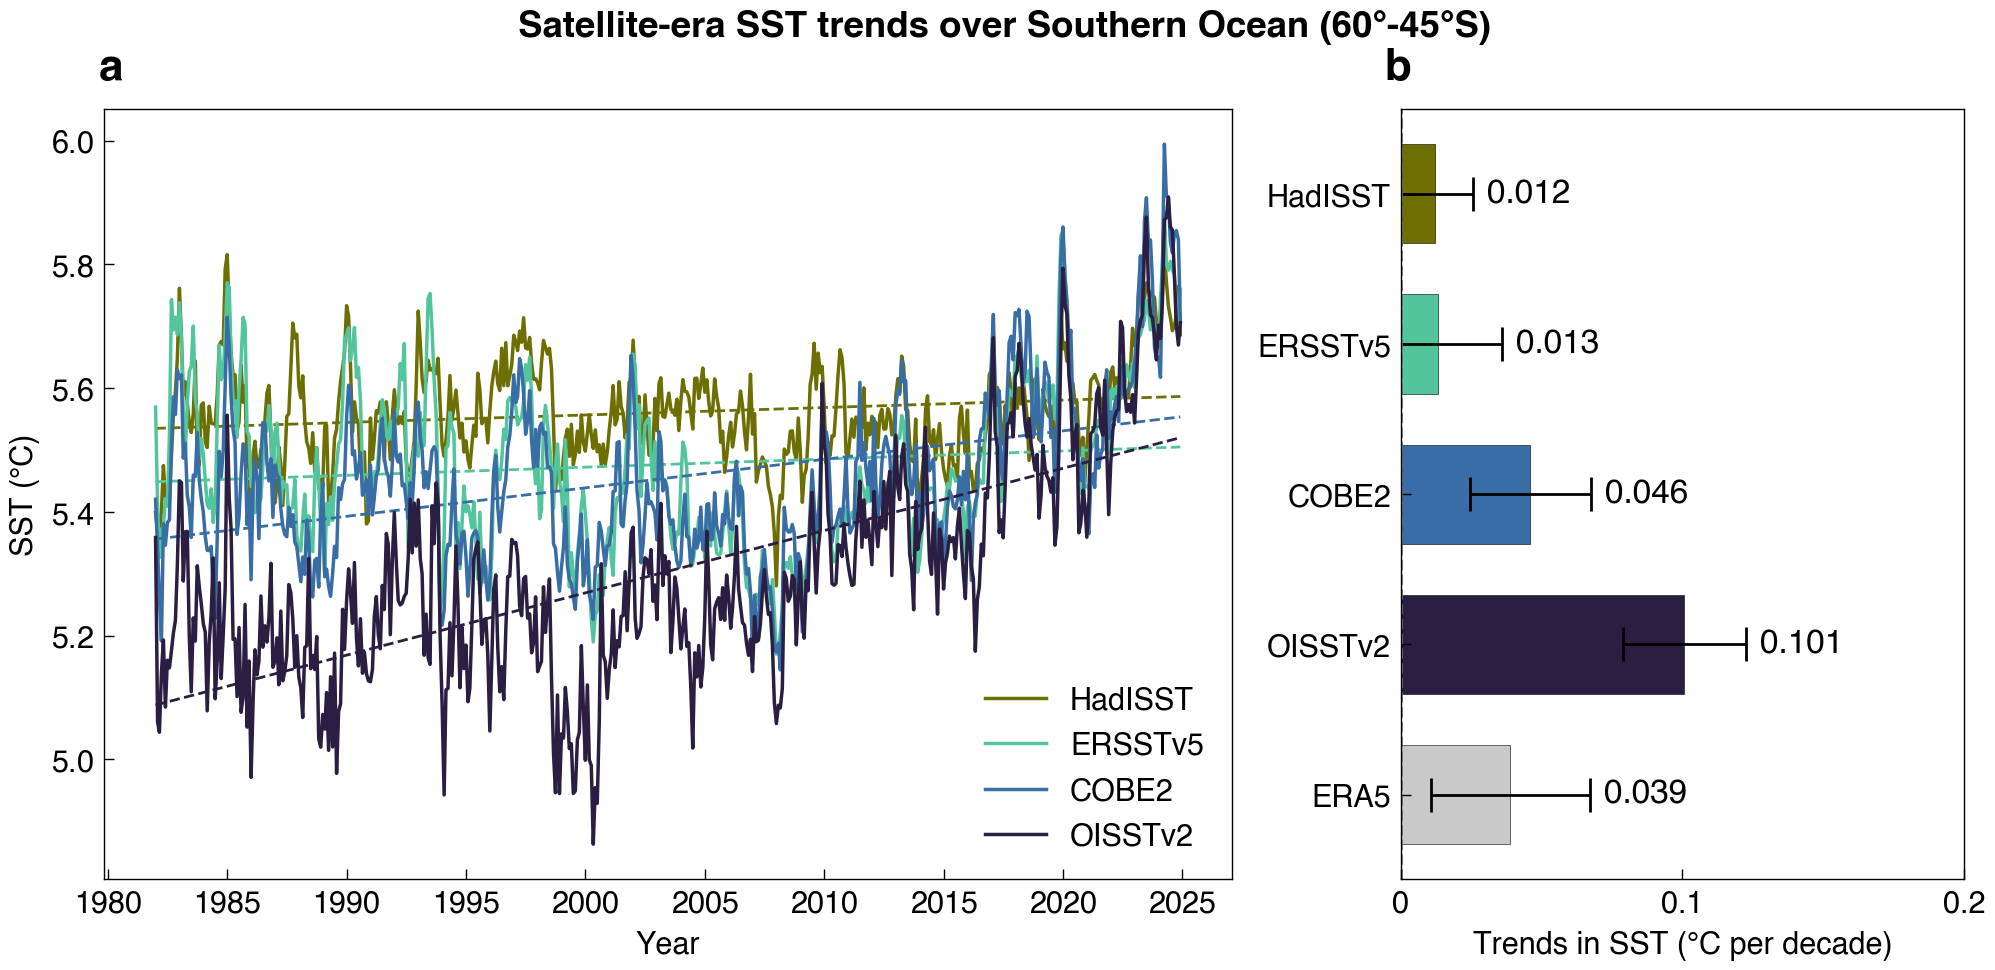

In [6]:
model_i_ad_60S45S, trend_i_ad_60S45S = load_area_average_sst_trend(region=[0, 360, -60, -45])
fig = plot_sst_trends(model_i_ad_60S45S, trend_i_ad_60S45S, suptitle='Satellite-era SST trends over Southern Ocean (60°-45°S)', 
                     xlim=[0, 0.2], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])
sp.savefig(fig, fname='sst_trend_SouthernOcean.png', dpi=300)

### Extratropical Southern Hermisphere (30°-60°S)

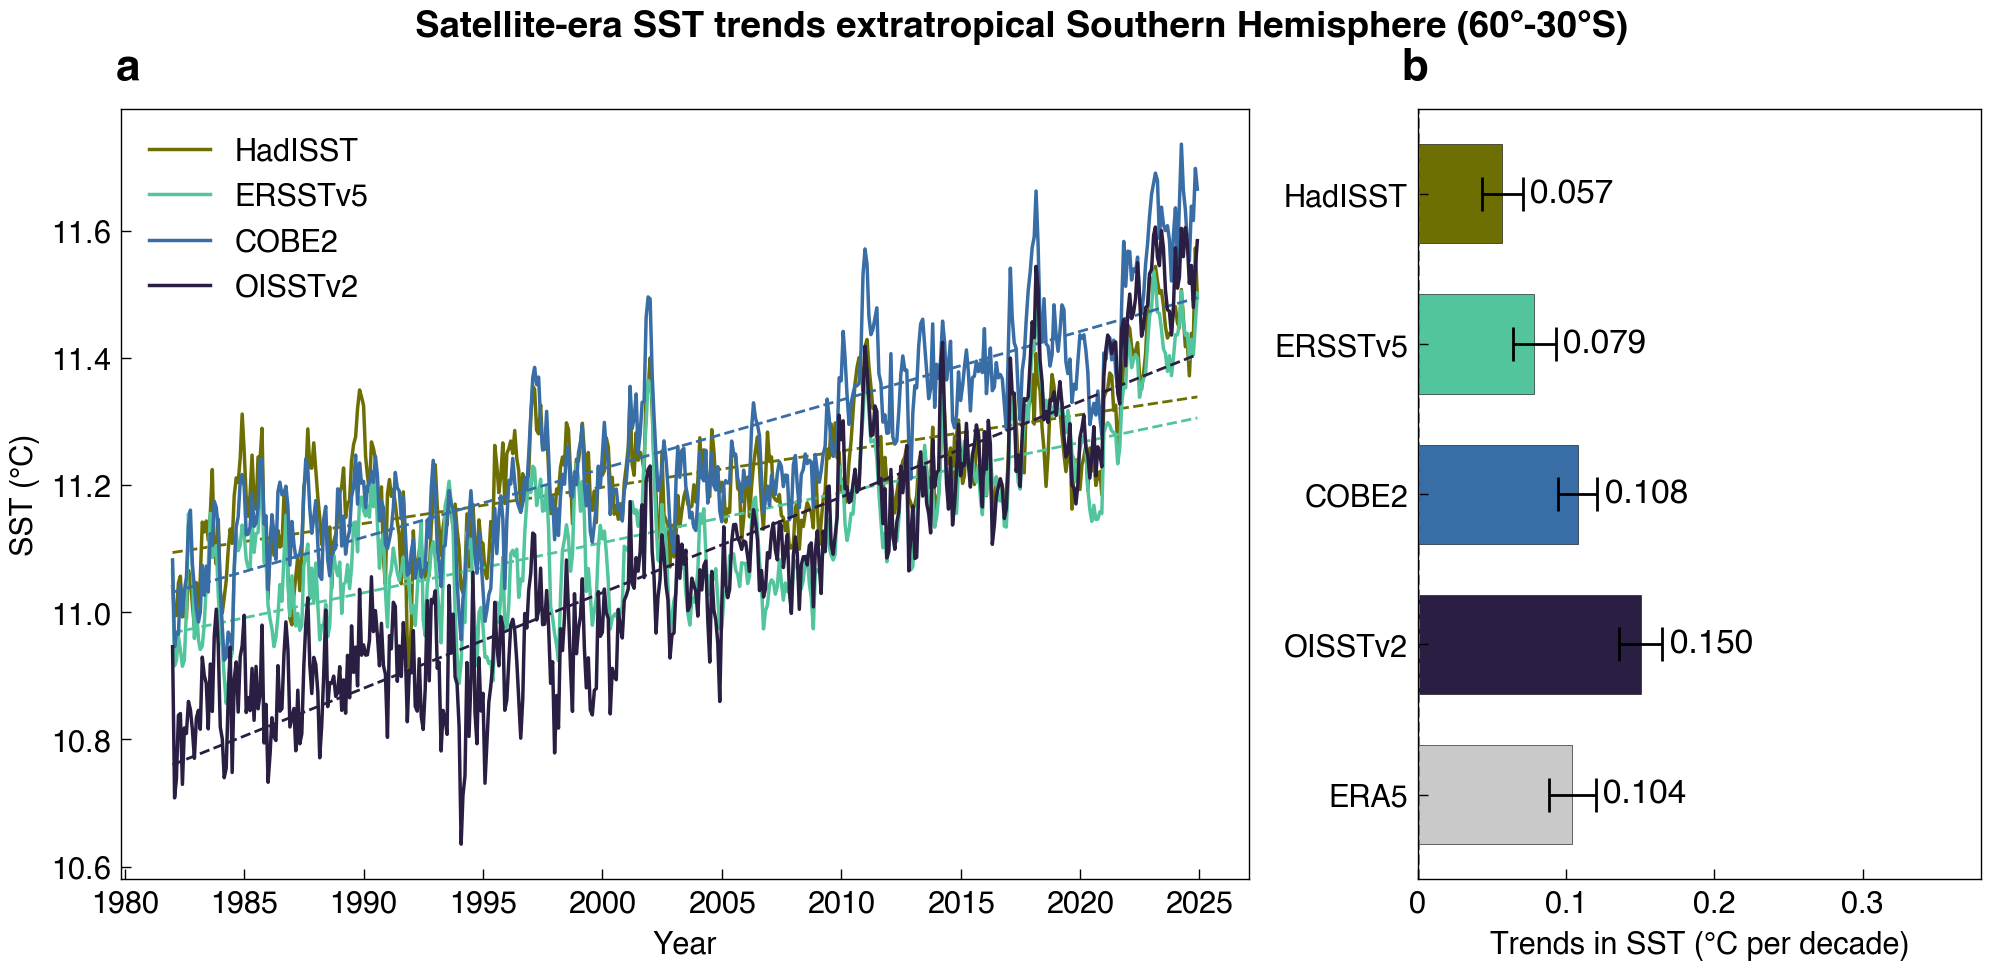

In [7]:
model_i_ad_60S30S, trend_i_ad_60S30S = load_area_average_sst_trend(region=[0, 360, -60, -30])
fig = plot_sst_trends(model_i_ad_60S30S, trend_i_ad_60S30S, suptitle='Satellite-era SST trends extratropical Southern Hemisphere (60°-30°S)', 
                     xlim=[0, 0.38], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])

### ENSO Niño3.4 SST
Eastern equatorial Pacific does not show significant warming trend (even negative)

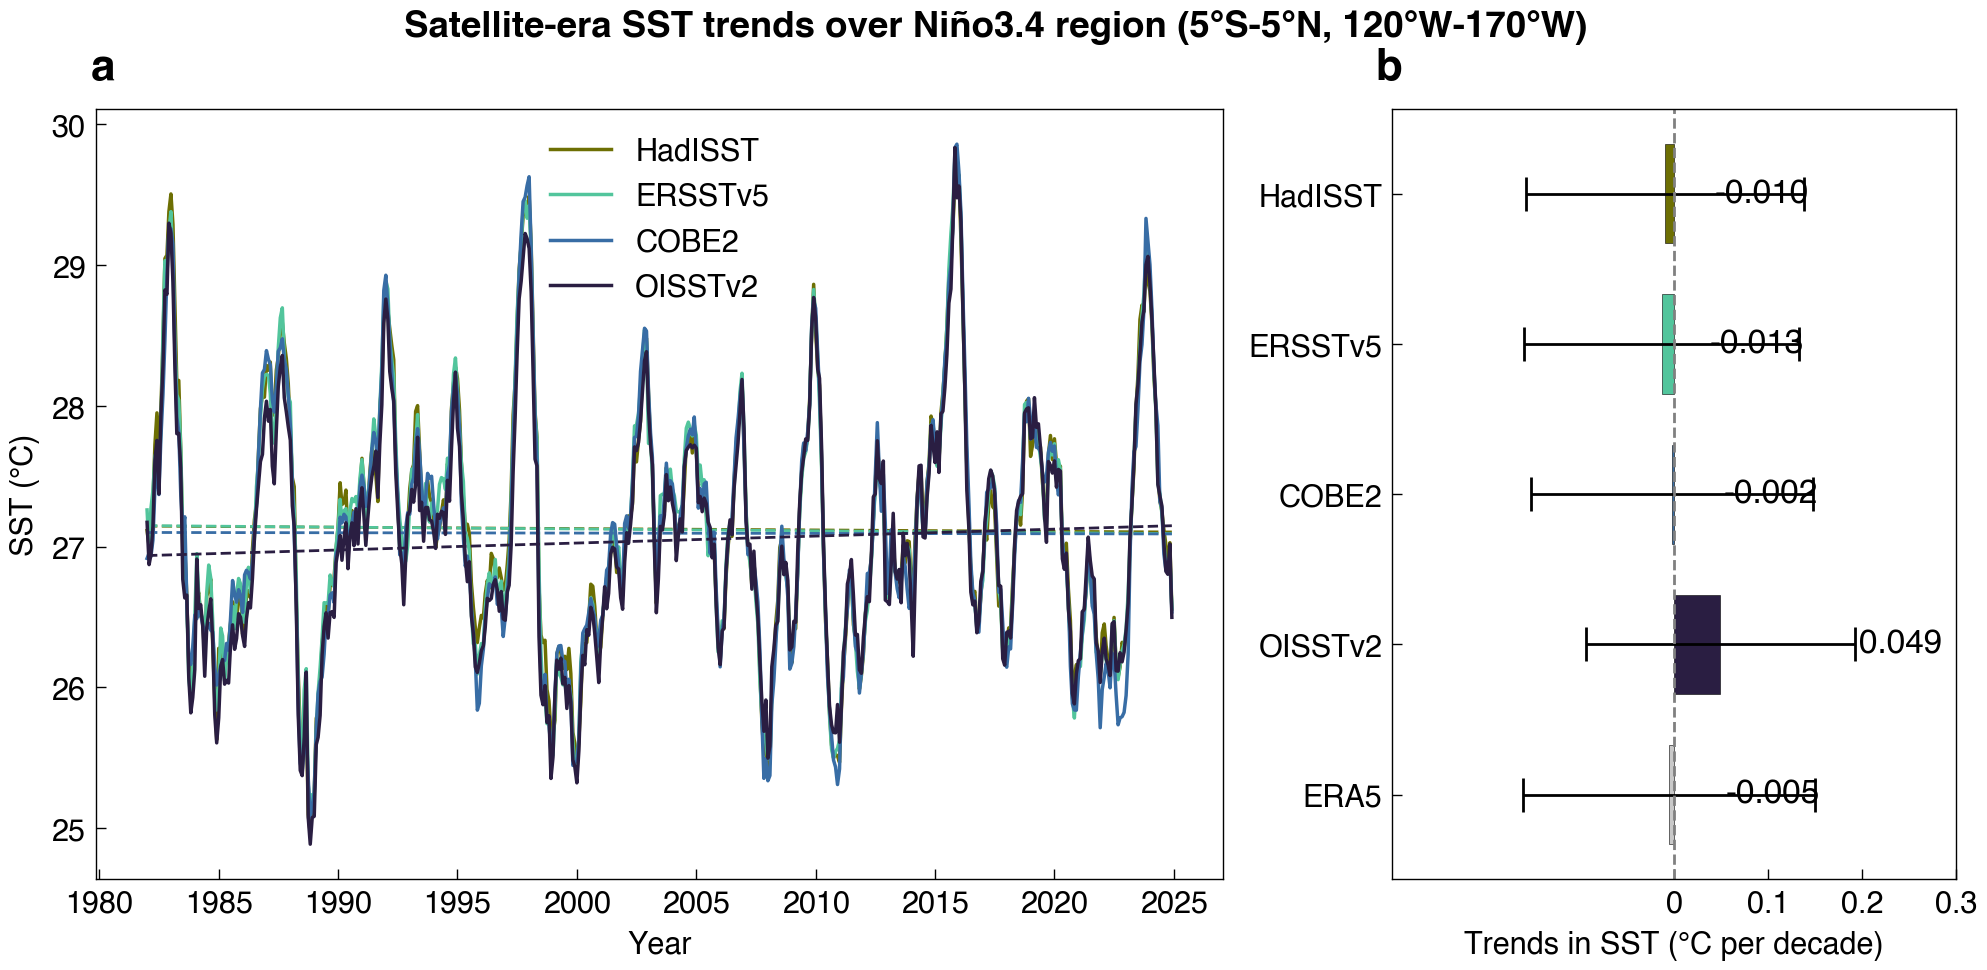

In [8]:
model_i_ad_Nino34, trend_i_ad_Nino34 = load_area_average_sst_trend(region="Nino34")
fig = plot_sst_trends(model_i_ad_Nino34, trend_i_ad_Nino34, suptitle='Satellite-era SST trends over Niño3.4 region (5°S-5°N, 120°W-170°W)', 
                     xlim=[-0.3, 0.3], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])

### Indian Ocean Basin warming

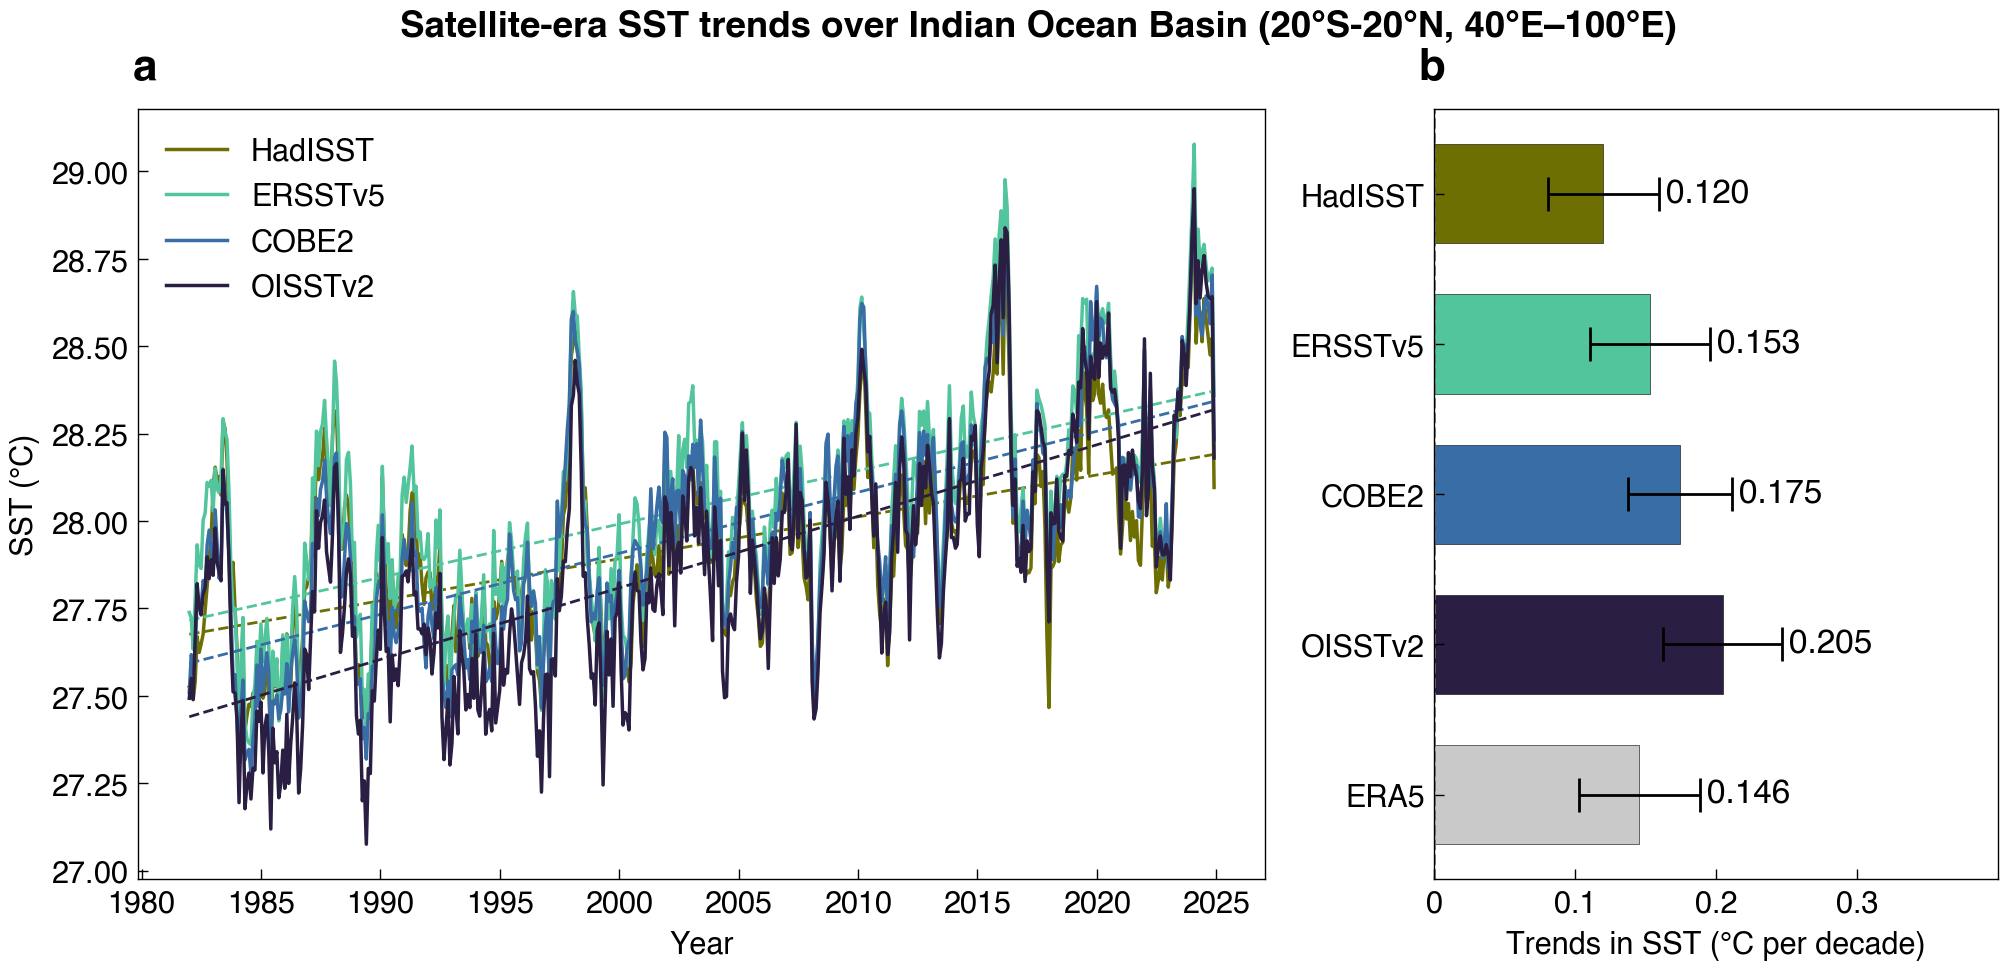

In [9]:
model_i_ad_IOB, trend_i_ad_IOB = load_area_average_sst_trend(region="IOB")
fig = plot_sst_trends(model_i_ad_IOB, trend_i_ad_IOB, suptitle='Satellite-era SST trends over Indian Ocean Basin (20°S-20°N, 40°E–100°E)', 
                     xlim=[0, 0.4], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])

### North Atlantic warming

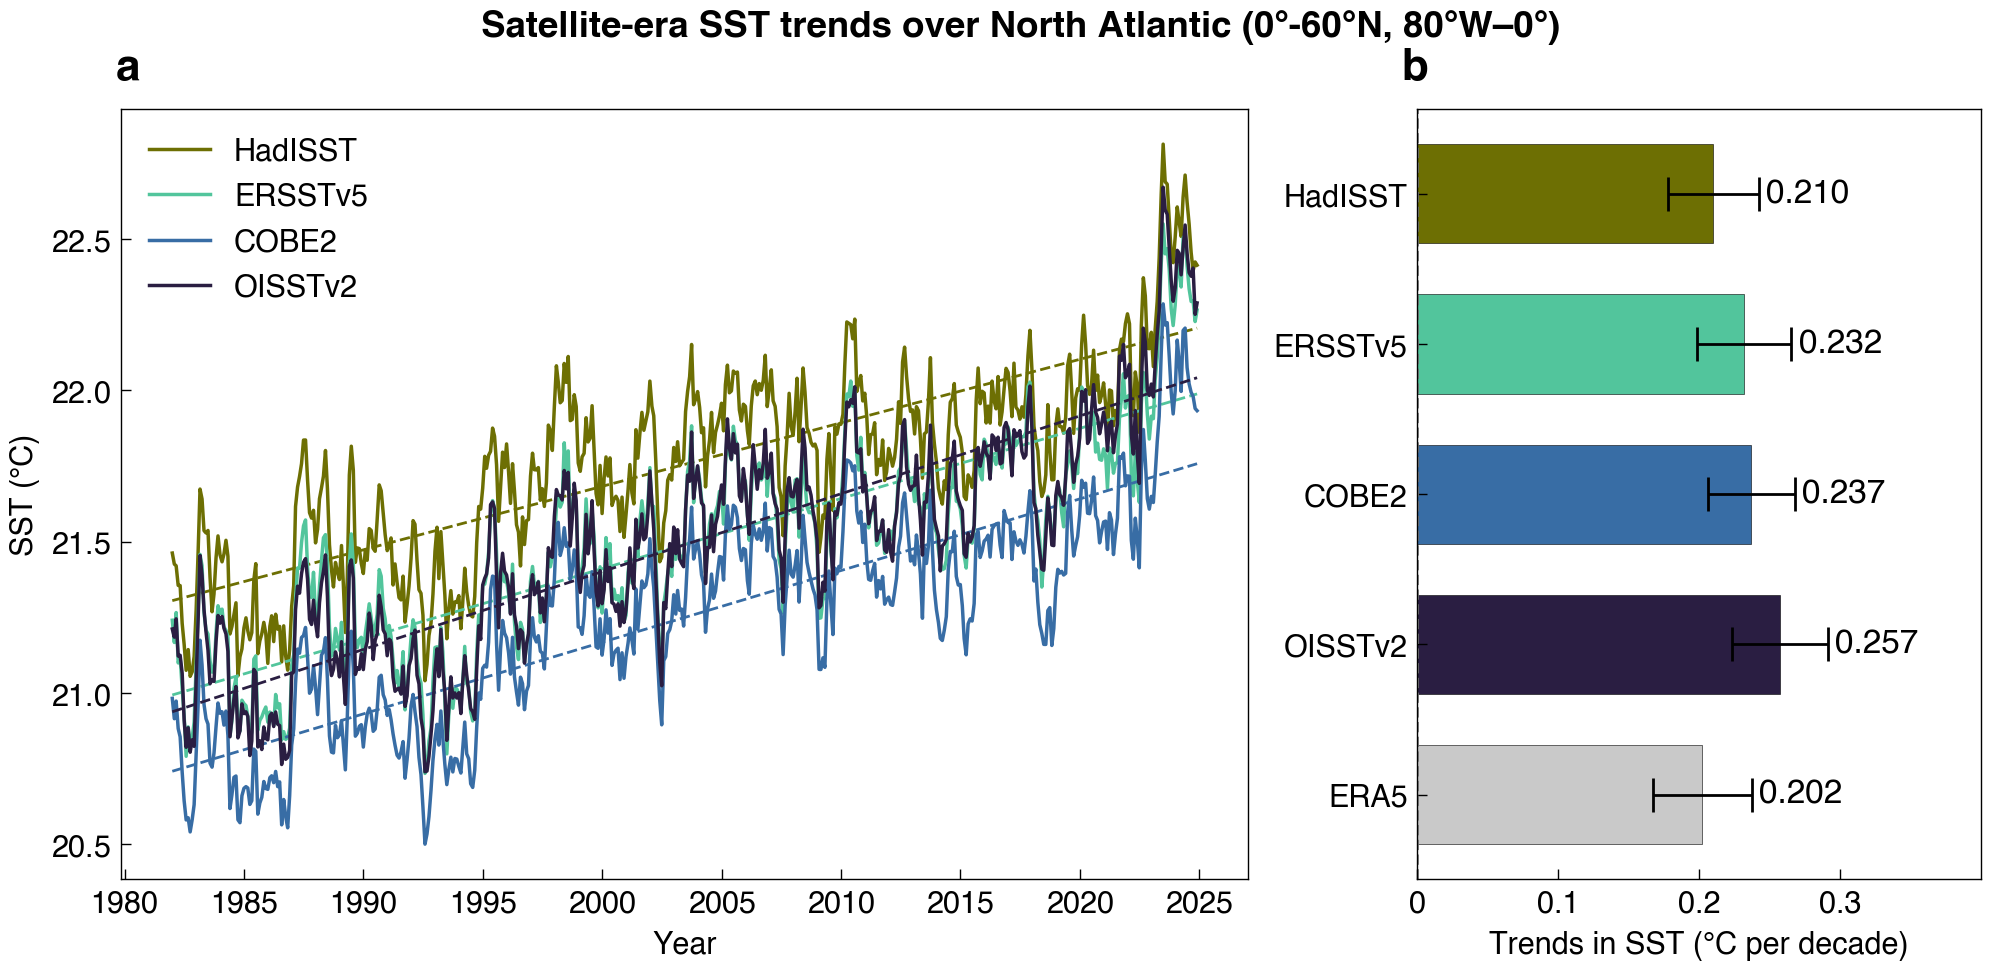

In [10]:
model_i_ad_NA, trend_i_ad_NA = load_area_average_sst_trend(region=[280, 360, 0, 60])
fig = plot_sst_trends(model_i_ad_NA, trend_i_ad_NA, suptitle='Satellite-era SST trends over North Atlantic (0°-60°N, 80°W–0°)', 
                     xlim=[0, 0.4], xticks=[0, 0.1, 0.2, 0.3], xticklabels=[0, 0.1, 0.2, 0.3])